# Set-up

In [69]:
import os
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from bs4 import BeautifulSoup
#from lxml import etree
from collections import defaultdict, Counter
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics, cluster, preprocessing
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
import seaborn as sns
%matplotlib inline
from sklearn import manifold, decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble \
import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
import timeit
import itertools
import pickle
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import SGDClassifier
from scipy.sparse import hstack

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
from google.colab import drive
drive.mount('/content/drive') 
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks")
import os 
os.chdir('/content/drive/My Drive/Colab Notebooks/P6_Catégorisez automatiquement des questions')

Mounted at /content/drive


# Constantes et fonctions

In [254]:
DICT_COLS = {'Title': [50, 1500, 500], 'Body': [100, 3000, 1000]}
SAMPLE = 5000
RATIO = 1/3

def tag_question(title, body):
    """
    Prediction function of stackexchange tags from a query passed as parameter
    """ 

    tokenizer = nltk.RegexpTokenizer(REGEX)
    lemmatizer = WordNetLemmatizer() 
    stemmer = PorterStemmer()

    #with open('OC_DS_P6_prod.pkl', 'rb') as file:
    #    unpickler = pickle.Unpickler(file)
    #    tfidf = unpickler.load()
    #    mod = unpickler.load()
    #    lbl = unpickler.load()

    title = clean_field(title, tknzr=tokenizer, sw=std_sw, \
                        lmtzr=lemmatizer, stmr=stemmer)
    title = ' '.join([w for w in title.split() \
                       if w not in EXTRA_SW and not w.isdigit()])

    body = clean_field(body, tknzr=tokenizer, sw=std_sw, \
                       lmtzr=lemmatizer, stmr=stemmer)
    body = ' '.join([w for w in body.split() \
                      if w not in EXTRA_SW and not w.isdigit()])
    
    tfidf_t = tfidf['Title'].transform([title])
    features_t = tfidf['Title'].get_feature_names()

    tfidf_b = tfidf['Body'].transform([body])
    features_b = tfidf['Body'].get_feature_names()

    tfidf_full = hstack([tfidf_t, tfidf_b])

    return get_tags(label.classes_, model.predict(tfidf_full)[0])
    
def avg_jacard(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''

    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

def recap_cols(df, cols):
    """
    Fonction de dénombrement du contenu des listes des colonnes (cols) de df
    """

    print('='*50, '\nDénombrenent des mots')
    
    for col in cols:
        freq[col] = Counter(' '.join(df[col].values).split()).most_common()
        print('\t{:6s} : {:>7d} dont {:>6d} distincts'.\
                format(col, sum(dict(freq[col]).values()), len(freq[col])))
    print('='*50)
        
    return freq

def get_tags(features, pred):
    """ 
    Fonction de récupératon des libellés des tags à partir de la prédiction
    """

    temp = set()

    for i in range(len(pred)):
        if pred[i] == 1:
            temp.update([features[i]])

    return '<{}>'.format('><'.join(temp))

def clean_field(col, tknzr, sw, lmtzr, stmr):
    """
    Fonction de tokenisation du contenu dont regex \w+, 
    suppression des stopwords, lemmatisation et racinisation
    """

    temp = []
    
    for w in tknzr.tokenize(col.lower()):
        if w not in sw and not w.isdigit():
            pos = get_wordnet_pos(w)
            if pos != 'n':
                continue
            else:
                temp.append(stmr.stem(lmtzr.lemmatize(w, pos)))
            
    return ' '.join(temp)

def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts
    """

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def conv_html(col):
    """
    Fonction de convertion de html en chaine standard
    """

    html = BeautifulSoup(col, 'html.parser')
    # Delete url strings
    for t in html.find_all('a'):
        t.replace_with('')
    # Delete code blocks
    for t in html.find_all('pre'):
        t.replace_with('')
    
    return html.get_text(' ', strip=True)

# Chargement

In [259]:
freq = defaultdict()

with open('OC_DS_P6_backup.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    source = unpickler.load()
    EXTRA_SW = unpickler.load()
    REGEX = unpickler.load()

freq = recap_cols(source, source.columns)

source.head()

Dénombrenent des mots
	Title  :  256593 dont   9998 distincts
	Body   : 1492769 dont  46197 distincts
	top_tags :  104592 dont    100 distincts


,Title,Body,top_tags
64767087,git data model,read understand git work hood diagram book git...,git
63429629,calcul v sql server result,simpl calcul sum eom count result valu calcul ...,sql sql-server
63072035,happen child branch merg parent branch master,think question elabor branch branch happen bra...,git
62824936,refer default constructor c# result cs8618,c# class default constructor design declar def...,c#
60928038,string datetim day week incorrect,simpl line code code day week throw except mon...,.net c# datetime


In [13]:
len(source.top_tags.unique())

3952

In [260]:
train = source.copy()

# LDA

In [ ]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=200,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern=REGEX,  
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(train.Body)
data_vectorized.shape

In [ ]:
#instantiate CountVectorizer() 
cv = CountVectorizer()
 
# this steps generates word counts for the words in your docs 
TF = cv.fit_transform(train.Title, train.Body)

In [ ]:
TF

<10000x3573 sparse matrix of type '<class 'numpy.int64'>'
	with 38866 stored elements in Compressed Sparse Row format>


        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0

In [ ]:
params = {'n_components' : np.arange(500, 5000, 500), 'learning_decay': [.5, .7, .9]}
clf = LatentDirichletAllocation()

print('{}\n{}\n{}'.format('='*30, 'lda', '-'*30))
dict_precision["lda"] = {}

gs = GridSearchCV(clf, params)
gs.fit(TF)

print("Best params:", gs.best_params_, '\n')
dict_precision["lda"]['clf'] = gs

lda
------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:790: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:790: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:790: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:790: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:790: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:790: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_ld

Best params: {'learning_decay': 0.5, 'n_components': 10} 



In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, cv.get_feature_names(), no_top_words)

NameError: ignored

# TF-IDF
Je crée un dictionnaire avec les vecteurs TFIDF pour les appeler dans la fonction finale

In [273]:
len(train[train.Body.str.contains('1st')])

344

In [278]:
DICT_COLS = {'Title': [100, 1500, 500], 'Body': [200, 3000, 1000]}

In [279]:
dict_tfidf = defaultdict(dict)

for col in DICT_COLS.keys():
    X = train[col]

    dict_tfidf['vector'][col] = TfidfVectorizer(token_pattern=REGEX, \
                                                stop_words=EXTRA_SW, \
                                                min_df=DICT_COLS[col][0], \
                                                #max_df=DICT_COLS[col][1], \
                                                max_features=1000\
                                                ).fit(X)
                                                #DICT_COLS[col][2])
                                                
    #v_tfidf = dict_tfidf['vector'][col].transform(X)
    cols = dict_tfidf['vector'][col].get_feature_names()
    #dict_tfidf['df'][col] = pd.DataFrame(v_tfidf.todense().tolist(), \
    #                                     columns=cols, index=train.index)
    #print(col, ':', dict_tfidf['df'][col].shape)
    print(len(cols), cols)

408 ['2d', 'access', 'across', 'address', 'aggreg', 'ajax', 'algorithm', 'android', 'angular', 'anim', 'anoth', 'api', 'app', 'append', 'applic', 'argument', 'array', 'asp', 'assign', 'async', 'attribut', 'avoid', 'aw', 'awk', 'axi', 'b', 'background', 'bar', 'base', 'bash', 'behavior', 'binari', 'bind', 'block', 'boolean', 'box', 'bracket', 'branch', 'build', 'button', 'byte', 'c', 'c#', 'c++', 'calcul', 'call', 'cannot', 'captur', 'case', 'categori', 'cell', 'chang', 'char', 'charact', 'chart', 'check', 'checkbox', 'child', 'class', 'claus', 'click', 'code', 'collect', 'color', 'column', 'combin', 'comma', 'command', 'commit', 'compar', 'comparison', 'compil', 'compon', 'concaten', 'condit', 'connect', 'const', 'constructor', 'contain', 'content', 'control', 'convert', 'copi', 'core', 'correct', 'count', 'cs', 'csv', 'custom', 'd3', 'dart', 'data', 'databas', 'datafram', 'dataset', 'date', 'datetim', 'day', 'db', 'decim', 'declar', 'default', 'defin', 'delet', 'depend', 'detect', 'df

# Clustering

## Title

In [17]:
X = dict_tfidf['vector']['Title'].transform(train.Title)
X.shape

(10000, 500)

### PCA

In [18]:
pca = decomposition.PCA(n_components=2)

X_trans = pca.fit_transform(X.todense())

print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

PCA 2 composants: [0.02399872 0.01610946] 0.040108180496778084


best clustering =  250 elapsed :  171.19863638900006


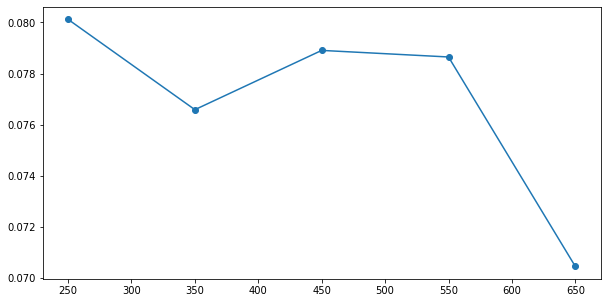

In [31]:
# Iteration de clustering kmeans avec des nb de clusters différents
silhouettes = []
cluster_range = range(250, 750, 100)

start_time = timeit.default_timer()
for n in cluster_range:
    myclust = cluster.KMeans(n_clusters=n, random_state=1)
    myclust.fit(X)
    silhouettes.append(metrics.silhouette_score(X, myclust.labels_))

elapsed = timeit.default_timer() - start_time
best_cluster = cluster_range[np.argmax(silhouettes)]
print('best clustering = ', best_cluster, 'elapsed : ', elapsed)

fig = plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouettes, marker='o')

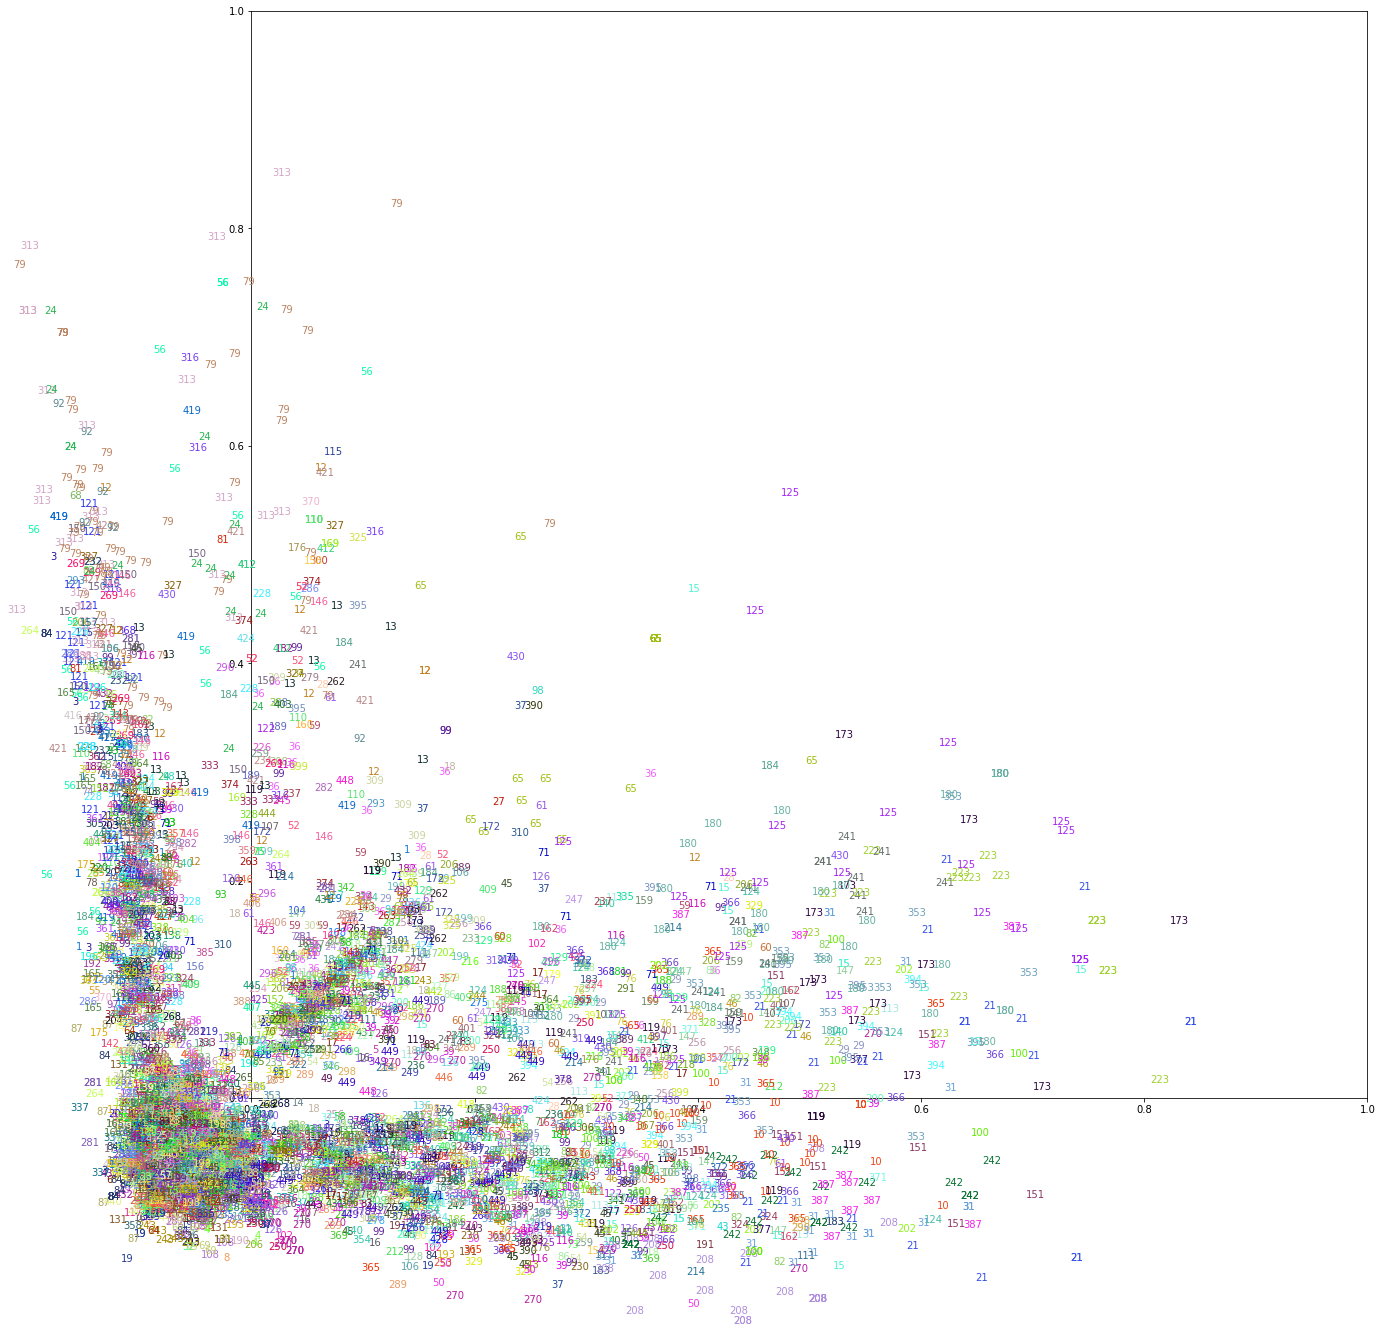

Silhouette Coefficient: 0.079


In [32]:
nb_clusters = 450
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 20))

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters, random_state=1)
myclust.fit(X)

# Puis on visualise 
for i in range(X.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], 
             myclust.labels_[i], color=color[myclust.labels_[i]] ) 
    #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
#plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
#plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

In [33]:
tfidf = pd.DataFrame(X.todense(), \
                     columns=dict_tfidf['vector']['Title'].get_feature_names(), 
                     index=train.index)

#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = tfidf.assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449
0,20,40,8,22,10,225,50,13,46,12,43,13,28,24,23,27,37,31,58,37,34,31,20,43,23,12,22,34,51,21,12,42,20,17,2,25,33,25,32,32,...,8,10,26,21,4,19,34,9,6,26,10,16,17,17,24,36,26,8,34,21,19,14,30,26,16,21,12,13,15,33,38,8,16,10,23,12,13,36,8,61


In [36]:
tfidf[tfidf.cluster == 4][['cluster']].merge(train[['Title', 'top_tags']], left_index=True, right_index=True)

,cluster,Title,top_tags
60558776,4,extract word word delimit python,python regex string
62153047,4,regex captur setenc word word list python,pandas python regex
62226479,4,word frequenc count group python,pandas python
63951946,4,charact text space except list word python,python regex
64061079,4,word python,python
64749798,4,word string python,python
65290426,4,python regex multipl word list,python regex
65320693,4,iter row column text word python,pandas python
65829037,4,word list string,list python string
66616964,4,distanc word python list,list python


# Classification supervisée

In [293]:
DICT_CLF = {'svm': {'clf': LinearSVC(), 
                    'params': {'C': np.logspace(-3, 3, 7), 
                               'loss': ['hinge','squared_hinge'], 
                               'penalty': ['l1', 'l2']}},
            #'knn': {'clf': KNeighborsClassifier(),
            #        'params': {'n_neighbors': np.arange(10, 100, 10)}}, 
            'sgd': {'clf': SGDClassifier(), 
                    'params': {'estimator__loss': ['hinge', 'log', 
                                                   'modified_huber', 
                                                   'squared_hinge', 'perceptron'], 
                               'estimator__penalty': ['l2', 'l1']}}, 
            'rfc': {'clf': RandomForestClassifier(), 
                    'params': {'estimator__criterion': ['entropy', 'gini'], 
                               'estimator__n_estimators': [50, 100, 150, 200],}}, 
            }

## Multi-labelisation des top tags

In [281]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(train.top_tags.str.split())
y = multilabel_binarizer.transform(train.top_tags.str.split())
y.shape

(52579, 100)

## Title

In [184]:
X = dict_tfidf['vector']['Title'].transform(train.Title)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7000, 85), (3000, 85), (7000, 100), (3000, 100))

In [78]:
dict_precision = {}

for k, v in DICT_CLF.items():
    clf = OneVsRestClassifier(v['clf'])
    clf_name = v['clf'].__class__.__name__
    print('{}\n{}\n{}'.format('='*30, clf_name, '-'*30))
    dict_precision[clf_name] = {}

    start_time = timeit.default_timer()
#    gs = GridSearchCV(clf, v['params'], cv=5, scoring='accuracy')
    clf.fit(X_train, y_train)
#    print("Best params:", gs.best_params_, '\n')
    dict_precision[clf_name]['clf'] = clf

    y_pred = clf.predict(X_test)
    elapsed = timeit.default_timer() - start_time

    precision = 100*metrics.accuracy_score(y_test, y_pred)
    print("Title : time {:.2f}s".format(elapsed))    
    print("Accuracy: {:.2f}%".format(precision))    
    print("Jacard score: {:.2f}\n".format(avg_jacard(y_test, y_pred)))

    dict_precision[clf_name]['precision'] = precision

LinearSVC
------------------------------
Title : time 1.08s
Accuracy: 27.70%
Jacard score: 45.50

KNeighborsClassifier
------------------------------
Title : time 48.98s
Accuracy: 15.90%
Jacard score: 28.85

SGDClassifier
------------------------------
Title : time 0.72s
Accuracy: 27.83%
Jacard score: 44.87

RandomForestClassifier
------------------------------
Title : time 97.40s
Accuracy: 27.97%
Jacard score: 44.74



## Title + Body

In [282]:
X_title = dict_tfidf['vector']['Title'].transform(train.Title)
X_body = dict_tfidf['vector']['Body'].transform(train.Body)
X = hstack([X_title, X_body])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36805, 1173), (15774, 1173), (36805, 100), (15774, 100))

In [283]:
dict_precision = {}

for k, v in DICT_CLF.items():
    clf = OneVsRestClassifier(v['clf'])
    clf_name = v['clf'].__class__.__name__
    print('{}\n{}\n{}'.format('='*30, clf_name, '-'*30))
    dict_precision[clf_name] = {}

    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    dict_precision[clf_name]['clf'] = clf

    y_pred = clf.predict(X_test)
    elapsed = timeit.default_timer() - start_time

    precision = 100*metrics.accuracy_score(y_test, y_pred)
    print("Title+Body: time {:.2f}s".format(elapsed))    
    print("Accuracy: {:.2f}%".format(precision))    
    print("Jacard score: {:.2f}\n".format(avg_jacard(y_test, y_pred)))

    dict_precision[clf_name]['precision'] = precision

LinearSVC
------------------------------
Title+Body: time 21.48s
Accuracy: 33.30%
Jacard score: 54.60

KNeighborsClassifier
------------------------------
Title+Body: time 2374.96s
Accuracy: 20.58%
Jacard score: 36.79

SGDClassifier
------------------------------
Title+Body: time 9.25s
Accuracy: 31.62%
Jacard score: 50.98

RandomForestClassifier
------------------------------
Title+Body: time 1479.46s
Accuracy: 38.40%
Jacard score: 55.71



Optimisation du meilleur classifier

In [286]:
clf = 'rfc'

In [294]:
gs = GridSearchCV(OneVsRestClassifier(DICT_CLF[clf]['clf']), 
                  DICT_CLF[clf]['params'], 
                  verbose=3, 
                  scoring=metrics.make_scorer(avg_jacard, 
                                              greater_is_better=True))
gs.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] estimator__criterion=entropy, estimator__n_estimators=50 ........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  estimator__criterion=entropy, estimator__n_estimators=50, score=51.449, total= 8.8min
[CV] estimator__criterion=entropy, estimator__n_estimators=50 ........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.8min remaining:    0.0s


[CV]  estimator__criterion=entropy, estimator__n_estimators=50, score=50.689, total= 8.5min
[CV] estimator__criterion=entropy, estimator__n_estimators=50 ........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 17.2min remaining:    0.0s


[CV]  estimator__criterion=entropy, estimator__n_estimators=50, score=50.359, total= 8.6min
[CV] estimator__criterion=entropy, estimator__n_estimators=50 ........
[CV]  estimator__criterion=entropy, estimator__n_estimators=50, score=50.609, total= 8.5min
[CV] estimator__criterion=entropy, estimator__n_estimators=50 ........
[CV]  estimator__criterion=entropy, estimator__n_estimators=50, score=50.976, total= 8.6min
[CV] estimator__criterion=entropy, estimator__n_estimators=100 .......


KeyboardInterrupt: ignored

In [205]:
print(gs.best_params_, '\n')

print('{}\n{}\n{}'.format('='*30, 
                          gs.estimator.estimator.__class__.__name__, 
                          '-'*30))

y_pred = gs.predict(X_test)

precision = 100*metrics.accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(precision))    
print("Jacard score: {:.2f}\n".format(avg_jacard(y_test, y_pred)))

{'estimator__loss': 'hinge', 'estimator__penalty': 'l1'} 

SGDClassifier
------------------------------
Accuracy: 23.93%
Jacard score: 43.53



# Export

In [295]:
clf = 'RandomForestClassifier'

with open('OC_DS_P6_prod.pkl', 'wb') as file:
    pickler = pickle.Pickler(file, pickle.HIGHEST_PROTOCOL) 
    pickler.dump(dict_tfidf['vector'])
    pickler.dump(dict_precision[clf]['clf'])
    pickler.dump(multilabel_binarizer)

# Test

In [297]:
titre1 = "Calculator vs SQL Server giving different results"
corps1 = "<p>I have a simple calculation <code>sum(eom_count)/ 3</code>. It results in a value of 82, rather than 84.</p> <p>When I use a calculator, I get 84:</p> <pre><code>select sum(eom_mbr_count ) from elig table = 252 select sum(eom_mbr_count/3) from elig table = 82 </code></pre> <p>Calculator on computer <code>252/3 = 84</code>, I know 84 is correct, your help is appreciated. Thanks</p>"
corps1 = conv_html(corps1)
corps1

'I have a simple calculation sum(eom_count)/ 3 . It results in a value of 82, rather than 84. When I use a calculator, I get 84: Calculator on computer 252/3 = 84 , I know 84 is correct, your help is appreciated. Thanks'

In [298]:
tag_question(titre1, corps1)

'<sql-server><sql>'

In [299]:
tag_question('how running sql query in command line ?', 'I try to make an simple api for querying a database')

'<sql>'

In [300]:
tag_question('refer default constructor c# result cs8618', 'c# class default constructor design declar def')

'<c#>'

In [296]:
std_sw = set(nltk.corpus.stopwords.words('english')) 

tokenizer = nltk.RegexpTokenizer(REGEX)
lemmatizer = WordNetLemmatizer() 
stemmer = PorterStemmer()

with open('OC_DS_P6_prod.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    tfidf = unpickler.load()
    model = unpickler.load()
    label = unpickler.load()